In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saniyaa01","key":"136ae9f18d5db455a1b8c8033ec30b41"}'}

In [3]:
import os
import zipfile

# Step 1: Make a directory for the Kaggle token
os.makedirs("/root/.kaggle", exist_ok=True)

# Step 2: Move the uploaded kaggle.json to that directory
!mv kaggle.json /root/.kaggle/kaggle.json

# Step 3: Set proper permissions (important!)
!chmod 600 /root/.kaggle/kaggle.json

# Step 4: Now you can download the dataset using Kaggle CLI
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

# Step 5: Unzip the downloaded file
with zipfile.ZipFile("covid19-radiography-database.zip", "r") as zip_ref:
    zip_ref.extractall("covid19-radiography-dataset")


Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
 84% 657M/778M [00:00<00:00, 1.33GB/s]
100% 778M/778M [00:00<00:00, 1.27GB/s]


#Train test split


In [4]:
import os
import shutil
from pathlib import Path
import random

random.seed(42)

# Set paths for source (downloaded data) and destination (processed train/test)
source_dir = Path("/content/covid19-radiography-dataset/COVID-19_Radiography_Dataset")
dest_dir = Path("/content/data/processed")  # You can change to anything you like

train_dir = dest_dir / "train_data_with_masks"
test_dir = dest_dir / "test_data_with_masks"

classes = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
split_ratio = 0.85

for cls in classes:
    print(f"Processing class: {cls}")

    # Paths to images and masks in raw data
    images_path = source_dir / cls / "images"
    masks_path = source_dir / cls / "masks"

    # List image files only
    all_images = [img for img in os.listdir(images_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(all_images)

    split_index = int(len(all_images) * split_ratio)
    train_imgs = all_images[:split_index]
    test_imgs = all_images[split_index:]

    # Create destination directories
    train_img_dir = train_dir / cls / "images"
    train_mask_dir = train_dir / cls / "masks"
    test_img_dir = test_dir / cls / "images"
    test_mask_dir = test_dir / cls / "masks"

    train_img_dir.mkdir(parents=True, exist_ok=True)
    train_mask_dir.mkdir(parents=True, exist_ok=True)
    test_img_dir.mkdir(parents=True, exist_ok=True)
    test_mask_dir.mkdir(parents=True, exist_ok=True)

    # Copy images and corresponding masks
    for img in train_imgs:
        shutil.copy(images_path / img, train_img_dir / img)
        mask_file = masks_path / img
        if mask_file.exists():
            shutil.copy(mask_file, train_mask_dir / img)

    for img in test_imgs:
        shutil.copy(images_path / img, test_img_dir / img)
        mask_file = masks_path / img
        if mask_file.exists():
            shutil.copy(mask_file, test_mask_dir / img)

    print(f"  Copied {len(train_imgs)} images (and masks if available) to {train_img_dir}")
    print(f"  Copied {len(test_imgs)} images (and masks if available) to {test_img_dir}")


Processing class: Normal
  Copied 8663 images (and masks if available) to /content/data/processed/train_data_with_masks/Normal/images
  Copied 1529 images (and masks if available) to /content/data/processed/test_data_with_masks/Normal/images
Processing class: COVID
  Copied 3073 images (and masks if available) to /content/data/processed/train_data_with_masks/COVID/images
  Copied 543 images (and masks if available) to /content/data/processed/test_data_with_masks/COVID/images
Processing class: Lung_Opacity
  Copied 5110 images (and masks if available) to /content/data/processed/train_data_with_masks/Lung_Opacity/images
  Copied 902 images (and masks if available) to /content/data/processed/test_data_with_masks/Lung_Opacity/images
Processing class: Viral Pneumonia
  Copied 1143 images (and masks if available) to /content/data/processed/train_data_with_masks/Viral Pneumonia/images
  Copied 202 images (and masks if available) to /content/data/processed/test_data_with_masks/Viral Pneumonia/

In [ ]:
augmentation and train_val split

In [5]:
!pip install tensorflow
!pip install albumentations

import tensorflow as tf
import albumentations as A
import cv2
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split

IMG_HEIGHT, IMG_WIDTH = 224, 224
NUM_CLASSES = 4
BATCH_SIZE = 16

CLASSES = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
CLASS_TO_INDEX = {cls: idx for idx, cls in enumerate(CLASSES)}

DATA_DIR = Path("/content/data/processed/train_data_with_masks")

# Albumentations augmentation pipeline
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=0, p=0.5),
])

# ----------- Dataset Preparation -----------

all_img_paths = []
all_class_indices = []

for class_name in CLASSES:
    class_dir = DATA_DIR / class_name / "images"
    img_files = list(class_dir.glob("*"))
    for img_file in img_files:
        all_img_paths.append(str(img_file))
        all_class_indices.append(CLASS_TO_INDEX[class_name])

# Train/val split
train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    all_img_paths, all_class_indices, test_size=0.2, stratify=all_class_indices, random_state=42
)

# ----------- Data Generator -----------
# Count how many images per class
from collections import Counter
class_counts = Counter(train_labels)
mean_count = np.mean(list(class_counts.values()))

# Define minority class indices
minority_classes = [cls for cls, count in class_counts.items() if count < mean_count]

def classification_generator(img_paths, labels):
    for img_path, label in zip(img_paths, labels):
        augment_flag = label in minority_classes
        img, lbl = load_classification_image(img_path, label, augment_data=augment_flag)
        yield img, lbl


def load_classification_image(img_path, label, augment_data=False):
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

    if augment_data:
        img = augment(image=img)['image']

    img = img.astype(np.float32) / 255.0
    img = np.stack([img]*3, axis=-1)  # convert grayscale to RGB
    return img, label


def create_classification_dataset(img_paths, labels, batch_size=16):
    dataset = tf.data.Dataset.from_generator(
        lambda: classification_generator(img_paths, labels),
        output_signature=(
            tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )
    dataset = dataset.shuffle(buffer_size=100)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_classification_dataset(train_imgs, train_labels, batch_size=BATCH_SIZE)
val_dataset = create_classification_dataset(val_imgs, val_labels, batch_size=BATCH_SIZE)


print(f"Train batches: {len(list(train_dataset))}")
print(f"Validation batches: {len(list(val_dataset))}")


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Train batches: 900
Validation batches: 225


#prepare test data


In [6]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
from pathlib import Path

TEST_DATA_DIR = Path("/content/data/processed/test_data_with_masks")

X_test_raw = []
y_test_raw = []

for cls_index, cls_name in enumerate(CLASSES):
    img_dir = TEST_DATA_DIR / cls_name / "images"
    img_files = list(img_dir.glob("*"))

    for img_file in img_files:
        img = load_img(img_file, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale')
        img_array = img_to_array(img).astype(np.float32) / 255.0
        img_array = np.repeat(img_array, repeats=3, axis=-1)  # Convert grayscale to RGB

        X_test_raw.append(img_array)
        y_test_raw.append(cls_index)  # Image-level class label

# Convert to NumPy arrays
X_test = np.array(X_test_raw, dtype=np.float32)
y_test = np.array(y_test_raw, dtype=np.int32)

print("X_test shape:", X_test.shape)  # (N, 224, 224, 3)
print("y_test shape:", y_test.shape)  # (N,)



X_test shape: (3176, 224, 224, 3)
y_test shape: (3176,)


In [7]:

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



#define model


In [8]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load VGG16 base without top
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze VGG16 layers

# Input
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  # Pass input through VGG16

# Classification head
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(5, activation='softmax')(x)  # 5 classes (adjust if needed)

# Build and compile model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,767,365 (60.15 MB)

 Trainable params: 1,052,677 (4.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
from tensorflow.keras.utils import plot_model

# Update this path to desired Google Drive folder
save_path = '/content/drive/MyDrive/model1.png'

plot_model(model, to_file=save_path, show_shapes=True, show_layer_names=True)
print(f"Model plot saved to: {save_path}")


Model plot saved to: /content/drive/MyDrive/model1.png


In [9]:
EPOCHS = 5
steps_per_epoch = len(train_imgs) // BATCH_SIZE
validation_steps = len(val_imgs) // BATCH_SIZE

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
)

Epoch 1/5
899/899 ━━━━━━━━━━━━━━━━━━━━ 123s 124ms/step - accuracy: 0.6906 - loss: 0.7880 - val_accuracy: 0.8574 - val_loss: 0.4168
Epoch 2/5
  1/899 ━━━━━━━━━━━━━━━━━━━━ 1:22:02 5s/step - accuracy: 1.0000 - loss: 0.1367

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


899/899 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 1.0000 - loss: 0.1367 - val_accuracy: 0.8563 - val_loss: 0.4104
Epoch 3/5
899/899 ━━━━━━━━━━━━━━━━━━━━ 114s 127ms/step - accuracy: 0.8448 - loss: 0.4283 - val_accuracy: 0.8686 - val_loss: 0.3661
Epoch 4/5
899/899 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.8571 - loss: 0.3153 - val_accuracy: 0.8630 - val_loss: 0.3717
Epoch 5/5
899/899 ━━━━━━━━━━━━━━━━━━━━ 114s 127ms/step - accuracy: 0.8651 - loss: 0.3724 - val_accuracy: 0.7598 - val_loss: 0.6419


In [10]:
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]:.4f} - Test Accuracy: {results[1]:.4f}")
#83 %

199/199 ━━━━━━━━━━━━━━━━━━━━ 26s 126ms/step - accuracy: 0.8014 - loss: 0.4954
Test Loss: 0.6333 - Test Accuracy: 0.7585


In [ ]:
# Save in the Keras format (recommended in TF 2.x)
model.save('model_vgg16_fullsize.keras')


In [11]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [12]:
save_path = '/content/drive/MyDrive/model_vgg16_fullsize.keras'


In [13]:
model.save(save_path)


In [14]:
import numpy as np

# Predict probabilities
y_pred_probs = model.predict(test_dataset)

# Convert probs to class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # shape: (num_samples,)


199/199 ━━━━━━━━━━━━━━━━━━━━ 22s 106ms/step


In [15]:
y_true = y_test  # shape: (num_samples,)


<Figure size 800x800 with 0 Axes>

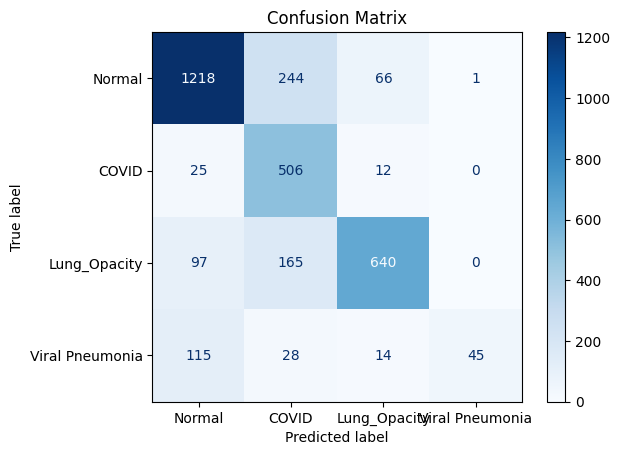

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)

plt.figure(figsize=(8,8))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [17]:

from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=CLASSES))

                 precision    recall  f1-score   support

         Normal       0.84      0.80      0.82      1529
          COVID       0.54      0.93      0.68       543
   Lung_Opacity       0.87      0.71      0.78       902
Viral Pneumonia       0.98      0.22      0.36       202

       accuracy                           0.76      3176
      macro avg       0.81      0.67      0.66      3176
   weighted avg       0.81      0.76      0.76      3176



#UNFREEZER LAST 4 LAYERS

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# Load base VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze last 4 convolutional layers
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Build the classification model
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)  # Set training=True for fine-tuning
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(4, activation='softmax')(x)  # Make sure NUM_CLASSES = 4

model = Model(inputs=inputs, outputs=outputs)

# Compile with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Optional callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
]




In [ ]:
from tensorflow.keras.utils import plot_model

# Update this path to  desired Google Drive folder
save_path = '/content/drive/MyDrive/model2.png'

plot_model(model, to_file=save_path, show_shapes=True, show_layer_names=True)
print(f"Model plot saved to: {save_path}")


Model plot saved to: /content/drive/MyDrive/model2.png


In [20]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
)


Epoch 1/5
    900/Unknown 118s 125ms/step - accuracy: 0.6538 - loss: 0.8297

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


900/900 ━━━━━━━━━━━━━━━━━━━━ 149s 160ms/step - accuracy: 0.6540 - loss: 0.8294 - val_accuracy: 0.8819 - val_loss: 0.3266
Epoch 2/5
900/900 ━━━━━━━━━━━━━━━━━━━━ 132s 147ms/step - accuracy: 0.8894 - loss: 0.3151 - val_accuracy: 0.8827 - val_loss: 0.3377
Epoch 3/5
900/900 ━━━━━━━━━━━━━━━━━━━━ 133s 147ms/step - accuracy: 0.9180 - loss: 0.2406 - val_accuracy: 0.9152 - val_loss: 0.2363
Epoch 4/5
900/900 ━━━━━━━━━━━━━━━━━━━━ 133s 147ms/step - accuracy: 0.9246 - loss: 0.2162 - val_accuracy: 0.9261 - val_loss: 0.2008
Epoch 5/5
900/900 ━━━━━━━━━━━━━━━━━━━━ 133s 147ms/step - accuracy: 0.9319 - loss: 0.1901 - val_accuracy: 0.9266 - val_loss: 0.1887


In [21]:
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]:.4f} - Test Accuracy: {results[1]:.4f}")


199/199 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - accuracy: 0.9069 - loss: 0.2500
Test Loss: 0.3241 - Test Accuracy: 0.8810


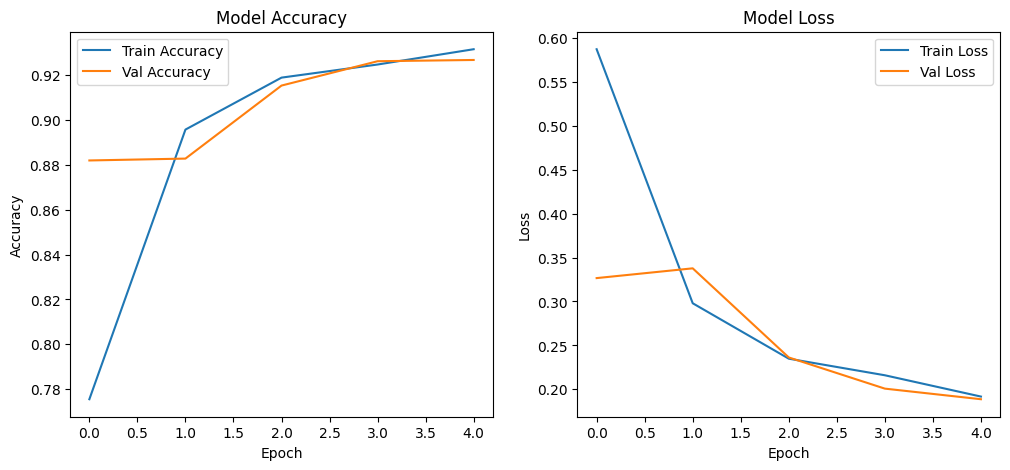

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Plot training & validation accuracy values
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

199/199 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step


<Figure size 800x800 with 0 Axes>

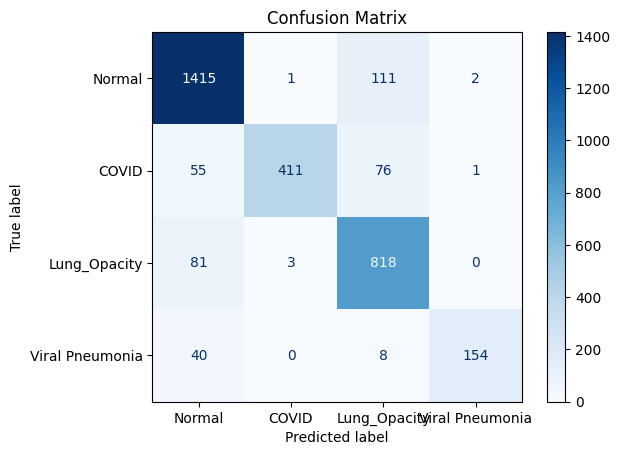

In [23]:
import numpy as np

# Predict probabilities
y_pred_probs = model.predict(test_dataset)

# Convert probs to class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # shape: (num_samples,)
y_true = y_test  # shape: (num_samples,)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)

plt.figure(figsize=(8,8))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=CLASSES))

                 precision    recall  f1-score   support

         Normal       0.89      0.93      0.91      1529
          COVID       0.99      0.76      0.86       543
   Lung_Opacity       0.81      0.91      0.85       902
Viral Pneumonia       0.98      0.76      0.86       202

       accuracy                           0.88      3176
      macro avg       0.92      0.84      0.87      3176
   weighted avg       0.89      0.88      0.88      3176



In [25]:
from google.colab import drive
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/model_vgg16_fullsize2.keras'
model.save(save_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
save_path = '/content/drive/MyDrive/model_vgg16_fullsize2.keras'
model.save(save_path)

In [27]:
#Key Improvements:
#More fine-tuned layers (last 8 instead of 4 for deeper adaptation).
#Batch normalization after Dense layers (helps with stable learning).
#Model checkpoint saving best model.
#Efficient learning rate schedule + monitoring
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# ---- Base Model ----
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the last 8 conv layers
for layer in base_model.layers[:-8]:
    layer.trainable = False
for layer in base_model.layers[-8:]:
    layer.trainable = True

# ---- Classification Head ----
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs, outputs)

# ---- Compile Model ----
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ---- Callbacks ----
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6),
    ModelCheckpoint("best_model_vgg16_finetuned.h5", save_best_only=True, monitor='val_loss')
]



In [ ]:
from tensorflow.keras.utils import plot_model

# Update this path to your desired Google Drive folder
save_path = '/content/drive/MyDrive/model3.png'

plot_model(model, to_file=save_path, show_shapes=True, show_layer_names=True)
print(f"Model plot saved to: {save_path}")


Model plot saved to: /content/drive/MyDrive/model3.png


In [28]:
# ---- Train Model ----
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
    900/Unknown 162s 167ms/step - accuracy: 0.6675 - loss: 0.9380

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


900/900 ━━━━━━━━━━━━━━━━━━━━ 187s 194ms/step - accuracy: 0.6676 - loss: 0.9377 - val_accuracy: 0.8822 - val_loss: 0.3619 - learning_rate: 1.0000e-05
Epoch 2/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8710 - loss: 0.4120

900/900 ━━━━━━━━━━━━━━━━━━━━ 169s 187ms/step - accuracy: 0.8710 - loss: 0.4120 - val_accuracy: 0.8966 - val_loss: 0.2903 - learning_rate: 1.0000e-05
Epoch 3/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 168s 186ms/step - accuracy: 0.9009 - loss: 0.3160 - val_accuracy: 0.8630 - val_loss: 0.3915 - learning_rate: 1.0000e-05
Epoch 4/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 168s 186ms/step - accuracy: 0.9043 - loss: 0.2887 - val_accuracy: 0.8772 - val_loss: 0.3581 - learning_rate: 1.0000e-05
Epoch 5/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9204 - loss: 0.2415

900/900 ━━━━━━━━━━━━━━━━━━━━ 169s 187ms/step - accuracy: 0.9204 - loss: 0.2415 - val_accuracy: 0.9386 - val_loss: 0.1745 - learning_rate: 2.0000e-06
Epoch 6/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 168s 186ms/step - accuracy: 0.9273 - loss: 0.2231 - val_accuracy: 0.9411 - val_loss: 0.1840 - learning_rate: 2.0000e-06
Epoch 7/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9320 - loss: 0.2069

900/900 ━━━━━━━━━━━━━━━━━━━━ 169s 187ms/step - accuracy: 0.9320 - loss: 0.2069 - val_accuracy: 0.9416 - val_loss: 0.1657 - learning_rate: 2.0000e-06
Epoch 8/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9393 - loss: 0.1873

900/900 ━━━━━━━━━━━━━━━━━━━━ 168s 187ms/step - accuracy: 0.9393 - loss: 0.1873 - val_accuracy: 0.9452 - val_loss: 0.1591 - learning_rate: 2.0000e-06
Epoch 9/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 168s 187ms/step - accuracy: 0.9386 - loss: 0.1828 - val_accuracy: 0.9394 - val_loss: 0.1711 - learning_rate: 2.0000e-06
Epoch 10/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9382 - loss: 0.1831

900/900 ━━━━━━━━━━━━━━━━━━━━ 169s 187ms/step - accuracy: 0.9382 - loss: 0.1831 - val_accuracy: 0.9452 - val_loss: 0.1513 - learning_rate: 2.0000e-06
Epoch 11/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 168s 187ms/step - accuracy: 0.9476 - loss: 0.1557 - val_accuracy: 0.9419 - val_loss: 0.1644 - learning_rate: 2.0000e-06
Epoch 12/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 168s 186ms/step - accuracy: 0.9489 - loss: 0.1491 - val_accuracy: 0.9377 - val_loss: 0.1896 - learning_rate: 2.0000e-06
Epoch 13/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 168s 186ms/step - accuracy: 0.9506 - loss: 0.1459 - val_accuracy: 0.9480 - val_loss: 0.1592 - learning_rate: 1.0000e-06
Epoch 14/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 168s 186ms/step - accuracy: 0.9529 - loss: 0.1432 - val_accuracy: 0.9466 - val_loss: 0.1514 - learning_rate: 1.0000e-06
Epoch 15/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 168s 186ms/step - accuracy: 0.9581 - loss: 0.1304 - val_accuracy: 0.9483 - val_loss: 0.1577 - learning_rate: 1.0000e-06


In [29]:
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]:.4f} - Test Accuracy: {results[1]:.4f}")


199/199 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.9359 - loss: 0.1726
Test Loss: 0.2546 - Test Accuracy: 0.9106


In [30]:
from google.colab import drive
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/model_vgg16_fullsize3.keras'
model.save(save_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
save_path = '/content/drive/MyDrive/model_vgg16_fullsize3.keras'
model.save(save_path)

199/199 ━━━━━━━━━━━━━━━━━━━━ 22s 107ms/step


<Figure size 800x800 with 0 Axes>

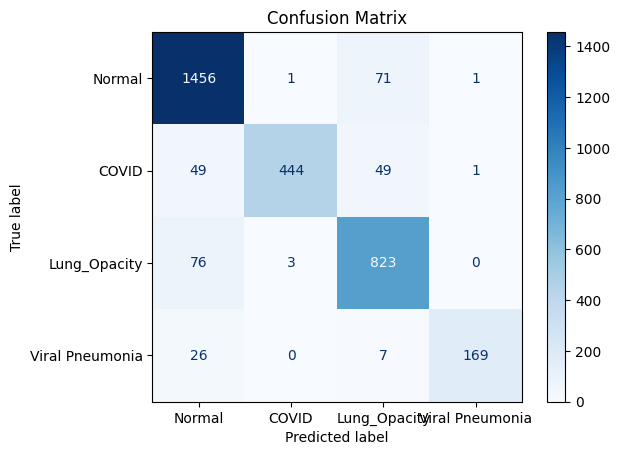

In [32]:
import numpy as np

# Predict probabilities
y_pred_probs = model.predict(test_dataset)

# Convert probs to class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # shape: (num_samples,)
y_true = y_test  # shape: (num_samples,)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)

plt.figure(figsize=(8,8))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [33]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=CLASSES))

                 precision    recall  f1-score   support

         Normal       0.91      0.95      0.93      1529
          COVID       0.99      0.82      0.90       543
   Lung_Opacity       0.87      0.91      0.89       902
Viral Pneumonia       0.99      0.84      0.91       202

       accuracy                           0.91      3176
      macro avg       0.94      0.88      0.90      3176
   weighted avg       0.91      0.91      0.91      3176



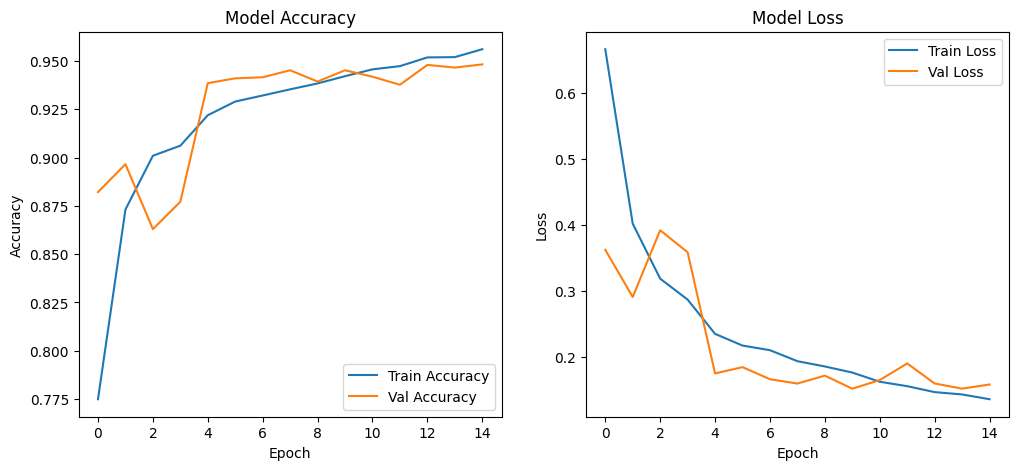

In [34]:
# Plot training & validation accuracy values
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

#unfreeze last 15 low lr

In [35]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Load VGG16 base
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[-15:]:
    layer.trainable = True


# Classification head
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(4, activation='softmax')(x)  # NUM_CLASSES = 4

model = Model(inputs=inputs, outputs=outputs)

# Compile with low LR for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#  Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6),
    ModelCheckpoint('vgg16_finetuned_all_layers.h5', save_best_only=True, monitor='val_accuracy', verbose=1)
]



In [ ]:
from tensorflow.keras.utils import plot_model

# Update this path to desired Google Drive folder
save_path = '/content/drive/MyDrive/model4.png'

plot_model(model, to_file=save_path, show_shapes=True, show_layer_names=True)
print(f"Model plot saved to: {save_path}")


Model plot saved to: /content/drive/MyDrive/model4.png


In [36]:
# Training
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=len(train_imgs) // BATCH_SIZE,
    validation_steps=len(val_imgs) // BATCH_SIZE,
    callbacks=callbacks
)


Epoch 1/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.6844 - loss: 0.7625
Epoch 1: val_accuracy improved from -inf to 0.90541, saving model to vgg16_finetuned_all_layers.h5


899/899 ━━━━━━━━━━━━━━━━━━━━ 293s 298ms/step - accuracy: 0.6845 - loss: 0.7622 - val_accuracy: 0.9054 - val_loss: 0.2693 - learning_rate: 1.0000e-05
Epoch 2/10
  1/899 ━━━━━━━━━━━━━━━━━━━━ 2:57:13 12s/step - accuracy: 0.8571 - loss: 0.4215

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.90541
899/899 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.8571 - loss: 0.4215 - val_accuracy: 0.8976 - val_loss: 0.2871 - learning_rate: 1.0000e-05
Epoch 3/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9036 - loss: 0.2753
Epoch 3: val_accuracy improved from 0.90541 to 0.92494, saving model to vgg16_finetuned_all_layers.h5


899/899 ━━━━━━━━━━━━━━━━━━━━ 269s 299ms/step - accuracy: 0.9036 - loss: 0.2753 - val_accuracy: 0.9249 - val_loss: 0.2061 - learning_rate: 1.0000e-05
Epoch 4/10
  1/899 ━━━━━━━━━━━━━━━━━━━━ 2:09 144ms/step - accuracy: 0.8571 - loss: 0.4849
Epoch 4: val_accuracy did not improve from 0.92494
899/899 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.8571 - loss: 0.4849 - val_accuracy: 0.9222 - val_loss: 0.2101 - learning_rate: 1.0000e-05
Epoch 5/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9320 - loss: 0.1957
Epoch 5: val_accuracy improved from 0.92494 to 0.93890, saving model to vgg16_finetuned_all_layers.h5


899/899 ━━━━━━━━━━━━━━━━━━━━ 269s 299ms/step - accuracy: 0.9320 - loss: 0.1958 - val_accuracy: 0.9389 - val_loss: 0.1693 - learning_rate: 1.0000e-05
Epoch 6/10
  1/899 ━━━━━━━━━━━━━━━━━━━━ 2:02 137ms/step - accuracy: 0.8571 - loss: 0.2135
Epoch 6: val_accuracy did not improve from 0.93890
899/899 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.8571 - loss: 0.2135 - val_accuracy: 0.9378 - val_loss: 0.1744 - learning_rate: 1.0000e-05
Epoch 7/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9406 - loss: 0.1743
Epoch 7: val_accuracy did not improve from 0.93890
899/899 ━━━━━━━━━━━━━━━━━━━━ 268s 298ms/step - accuracy: 0.9406 - loss: 0.1743 - val_accuracy: 0.9244 - val_loss: 0.2066 - learning_rate: 1.0000e-05
Epoch 8/10
  1/899 ━━━━━━━━━━━━━━━━━━━━ 2:08 143ms/step - accuracy: 1.0000 - loss: 0.0354
Epoch 8: val_accuracy did not improve from 0.93890
899/899 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 1.0000 - loss: 0.0354 - val_accuracy: 0.9244 - val_loss: 0.2044 - learning_rate

899/899 ━━━━━━━━━━━━━━━━━━━━ 269s 299ms/step - accuracy: 0.9539 - loss: 0.1364 - val_accuracy: 0.9442 - val_loss: 0.1542 - learning_rate: 2.0000e-06
Epoch 10/10
  1/899 ━━━━━━━━━━━━━━━━━━━━ 2:03 138ms/step - accuracy: 1.0000 - loss: 0.0568
Epoch 10: val_accuracy did not improve from 0.94420
899/899 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 1.0000 - loss: 0.0568 - val_accuracy: 0.9431 - val_loss: 0.1536 - learning_rate: 2.0000e-06


In [37]:
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]:.4f} - Test Accuracy: {results[1]:.4f}")


199/199 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - accuracy: 0.9338 - loss: 0.1984
Test Loss: 0.2248 - Test Accuracy: 0.9197


199/199 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step


<Figure size 800x800 with 0 Axes>

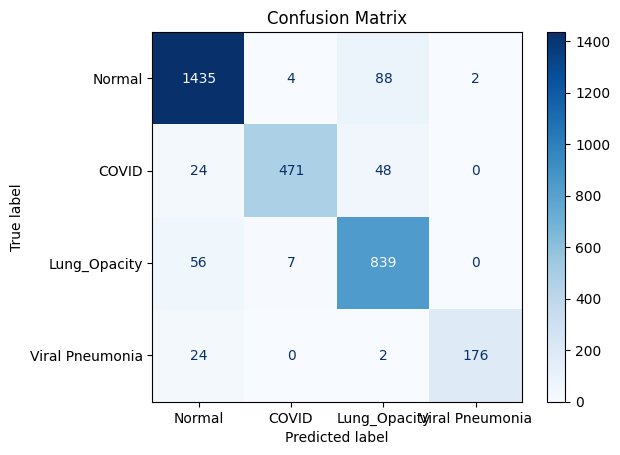

In [38]:
import numpy as np

# Predict probabilities
y_pred_probs = model.predict(test_dataset)

# Convert probs to class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # shape: (num_samples,)
y_true = y_test  # shape: (num_samples,)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)

plt.figure(figsize=(8,8))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=CLASSES))

                 precision    recall  f1-score   support

         Normal       0.94      0.91      0.93      1529
          COVID       0.91      0.96      0.93       543
   Lung_Opacity       0.87      0.92      0.90       902
Viral Pneumonia       0.99      0.87      0.92       202

       accuracy                           0.92      3176
      macro avg       0.93      0.91      0.92      3176
   weighted avg       0.92      0.92      0.92      3176



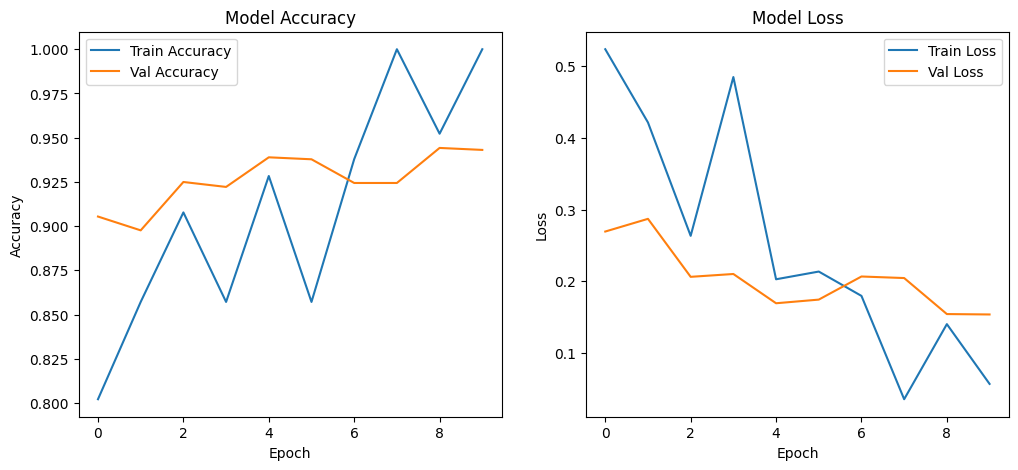

In [39]:
# Plot training & validation accuracy values
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [40]:
save_path = '/content/drive/MyDrive/model_vgg16_fullsizebest.keras'
model.save(save_path)


#efficient net


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Load EfficientNetB0 base (frozen)
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze all layers initially

# Build classification model
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  # training=False disables BN update
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(4, activation='softmax')(x)  # 4 classes

model = Model(inputs=inputs, outputs=outputs)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6),
    ModelCheckpoint('efficientnet_phase1.h5', save_best_only=True, monitor='val_accuracy', verbose=1)
]



In [ ]:
# Train
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=callbacks
)



Epoch 1/10
    900/Unknown 68s 54ms/step - accuracy: 0.3031 - loss: 1.7774

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.48166, saving model to efficientnet_phase1.h5


900/900 ━━━━━━━━━━━━━━━━━━━━ 86s 74ms/step - accuracy: 0.3031 - loss: 1.7773 - val_accuracy: 0.4817 - val_loss: 1.7475 - learning_rate: 1.0000e-04
Epoch 2/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3762 - loss: 1.4736
Epoch 2: val_accuracy did not improve from 0.48166
900/900 ━━━━━━━━━━━━━━━━━━━━ 49s 54ms/step - accuracy: 0.3762 - loss: 1.4736 - val_accuracy: 0.4817 - val_loss: 1.2124 - learning_rate: 1.0000e-04
Epoch 3/10
899/900 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4039 - loss: 1.4111
Epoch 3: val_accuracy did not improve from 0.48166
900/900 ━━━━━━━━━━━━━━━━━━━━ 48s 53ms/step - accuracy: 0.4039 - loss: 1.4110 - val_accuracy: 0.4817 - val_loss: 1.2022 - learning_rate: 1.0000e-04
Epoch 4/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4050 - loss: 1.3761
Epoch 4: val_accuracy improved from 0.48166 to 0.48666, saving model to efficientnet_phase1.h5


900/900 ━━━━━━━━━━━━━━━━━━━━ 49s 55ms/step - accuracy: 0.4050 - loss: 1.3761 - val_accuracy: 0.4867 - val_loss: 1.2562 - learning_rate: 1.0000e-04
Epoch 5/10
899/900 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4157 - loss: 1.3559
Epoch 5: val_accuracy did not improve from 0.48666
900/900 ━━━━━━━━━━━━━━━━━━━━ 50s 55ms/step - accuracy: 0.4157 - loss: 1.3559 - val_accuracy: 0.4817 - val_loss: 1.2030 - learning_rate: 1.0000e-04
Epoch 6/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4260 - loss: 1.3278
Epoch 6: val_accuracy did not improve from 0.48666
900/900 ━━━━━━━━━━━━━━━━━━━━ 49s 54ms/step - accuracy: 0.4260 - loss: 1.3278 - val_accuracy: 0.4817 - val_loss: 1.1842 - learning_rate: 2.0000e-05
Epoch 7/10
899/900 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4287 - loss: 1.3126
Epoch 7: val_accuracy did not improve from 0.48666
900/900 ━━━━━━━━━━━━━━━━━━━━ 48s 53ms/step - accuracy: 0.4287 - loss: 1.3126 - val_accuracy: 0.4817 - val_loss: 1.1804 - learning_rate: 2.0000e-0

In [ ]:
from tensorflow.keras.utils import plot_model

# Update this path to your desired Google Drive folder
save_path = '/content/drive/MyDrive/model5.png'

plot_model(model, to_file=save_path, show_shapes=True, show_layer_names=True)
print(f"Model plot saved to: {save_path}")



Model plot saved to: /content/drive/MyDrive/model5.png
